Projekt perceptronu na podstawie książki Python uczenie maszynowe


Klasa perceptron

..poczytać o bibliotekach

In [2]:
import numpy as np


class Perceptron(object):
    """
    Parametry
    ------------
    eta: zmiennoprzecinkowy współczynnik uczenia
    n_iter: liczba przebiegów po zestawach uczących całkowita
     Atrybuty
    -----------
    w_ : jednowymiarowa tablica
        Wagi po dopasowaniu.
    errors_ : lista
        Liczba nieprawidłowych klasyfikacji w każdej epoce.
    """

    def __init__(self, eta=0.01, n_iter=10, random_seed=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_seed = random_seed

    def fit(self, X, y):
        """Dopasowanie danych uczących.

        Parametry
        ----------
        X : {tablicopodobny}, wymiary = [n_próbek, n_cech]
            Wektory uczące, gdzie n_próbek
            oznacza liczbę próbek, a
            n_cech — liczbę cech.
        y : tablicopodobny, wymiary = [n_próbek]
            Wartości docelowe.

        Zwraca
        -------
        self : obiekt

        """
        rgen = np.random.RandomState(self.random_seed)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0] += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        "obliczna całkowite pobudzenie"
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        """Zwraca etykietę klas po obliczeniu funkcji skoku jednostkowego"""
        return np.where(self.net_input(X) >= 0.0, 1, -1)

# Trenowanie perceptronu

In [3]:
import pandas as pd
df = pd.read_csv(
    'https://archive.ics.uci.edu/ml/'
    'machine-learning-databases/iris/iris.data',
    header=None)
df.tail()

,0,1,2,3,4
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


# Rysowanie danych Iris

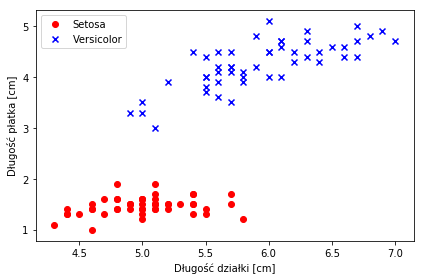

In [4]:
%config IPCompleter.greedy=True
%matplotlib inline
import matplotlib.pyplot as plt
# wybiera gatunki setosa i versicolor
y = df.iloc[0:100, 4].values
y = np.where(y == 'Iris-setosa', -1, 1)

# wydobywa cechy: długość działki i długość płatka
X = df.iloc[0:100, [0, 2]].values
#rsyuje wykres
plt.scatter(X[:50, 0], X[:50, 1], color='red', marker='o', label='Setosa')
plt.scatter(
    X[50:100, 0], X[50:100, 1], color='blue', marker='x', label='Versicolor')
plt.xlabel('Długość działki [cm]')
plt.ylabel('Długość płatka [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

## trenowanie perceptronu

In [5]:
ppn = Perceptron(eta=0.1, n_iter=10, random_seed=1)
ppn.fit(X, y)

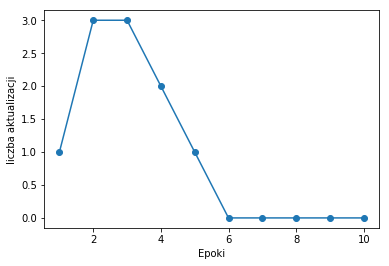

In [6]:
plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
plt.xlabel('Epoki')
plt.ylabel('liczba aktualizacji')
plt.show()

## Wizualizowanie granic decyzyjnych 

In [7]:
from matplotlib.colors import ListedColormap


def plot_decision_regions(X, y, classifier, resolution=0.02):
    #konfiguruje generator znaczników i mapę kolorów
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    #rysuje wykres powierzchni decyzyjnej
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(
        np.arange(x1_min, x1_max, resolution),
        np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    #rysuje wykres próbek
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(
            x=X[y == cl, 0],
            y=X[y == cl, 1],
            alpha=0.8,
            c=cmap(idx),
            marker=markers[idx],
            label=cl)

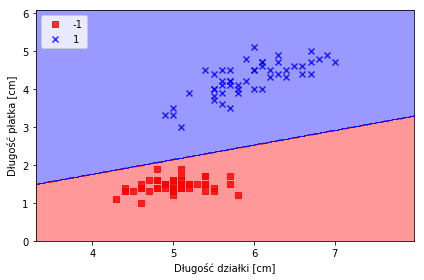

In [8]:
plot_decision_regions(X, y, classifier=ppn)
plt.xlabel('Długość działki [cm]')
plt.ylabel('Długość płatka [cm]')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('./rysunki/02_08.png', dpi=300)
plt.show()

# neuron adaptacyjny ADALINE implementacja

In [9]:
class AdalineGD(object):
    """Klasyfikator — ADAptacyjny LIniowy NEuron.

    Parametry
    ------------
    eta : zmiennoprzecinkowy
        Współczynnik uczenia (w zakresie pomiędzy 0.0 i 1.0)
    n_iter : liczba całkowita
        Liczba przebiegów po zestawie uczącym.

    Atrybuty
    -----------
   w_ : jednowymiarowa tablica
        Wagi po dopasowaniu.
    errors_ : lista
        Liczba niewłaściwych klasyfikacji w każdej epoce.

    """

    def __init__(self, eta=0.01, n_iter=50):
        self.eta = eta
        self.n_iter = n_iter

    def fit(self, X, y):
        """ Trenowanie za pomocą danych uczących.

        Parametry
        ----------
        X : {tablicopodobny}, wymiary = [n_próbek, n_cech]
            Wektory uczenia,
            gdzie n_próbek oznacza liczbę próbek, a
            n_cech – liczbę cech.
        y : tablicopodobny, wymiary = [n_próbek]
            Wartości docelowe.

        Zwraca
        -------
        self : obiekt

        """
        self.w_ = np.zeros(1 + X.shape[1])
        # tworzenie wejść z wagami na podstawie długości/szerokości sygnału wejściowego plus bias
        self.cost_ = []

        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        """oblicza całkowite pobudzenie"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Oblicza liniową funkcję aktywacji"""
        return self.net_input(X)

    def predict(self, X):
        """Zwraca etykietę klas po wykonaniu skoku jednostkowego"""
        return np.where(self.activation(X) >= 0.0, 1, -1)

Text(0.5,1,'Adaline - Współczynnik uczenia 0.0001')

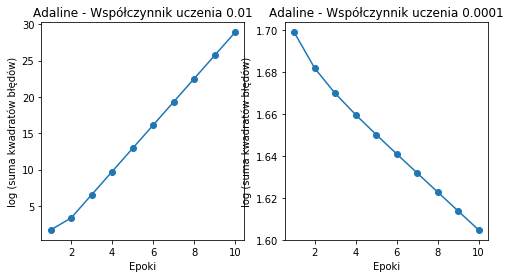

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

ada1 = AdalineGD(n_iter=10, eta=0.01).fit(X, y)
ax[0].plot(range(1, len(ada1.cost_) + 1), np.log10(ada1.cost_), marker='o')
ax[0].set_xlabel('Epoki')
ax[0].set_ylabel('log (suma kwadratów błędów)')
ax[0].set_title('Adaline - Współczynnik uczenia 0.01')

ada2 = AdalineGD(n_iter=10, eta=0.0001).fit(X, y)
ax[1].plot(range(1, len(ada2.cost_) + 1),np.log10(ada2.cost_), marker='o')
ax[1].set_xlabel('Epoki')
ax[1].set_ylabel('log (suma kwadratów błędów)')
ax[1].set_title('Adaline - Współczynnik uczenia 0.0001')



# standaryzacja cechy

In [12]:
X_std= np.copy(X)
X_std[:,0]= (X[:,0]-X[:,0].mean())/X[:,0].std()
X_std[:,1]= (X[:,1]-X[:,1].mean())/X[:,1].std()


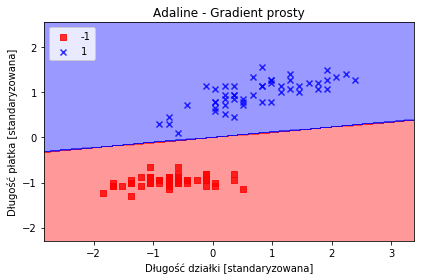

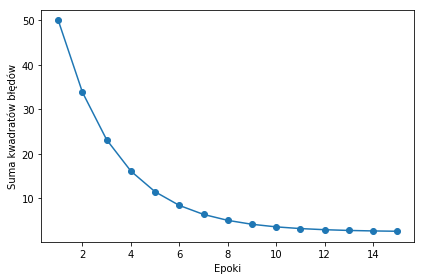

In [14]:
ada = AdalineGD(n_iter=15, eta=0.01)
ada.fit(X_std, y)

plot_decision_regions(X_std, y, classifier=ada)
plt.title('Adaline - Gradient prosty')
plt.xlabel('Długość działki [standaryzowana]')
plt.ylabel('Długość płatka [standaryzowana]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('./rysunki/02_13a.png', dpi=300)
plt.show()

plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')
plt.xlabel('Epoki')
plt.ylabel('Suma kwadratów błędów')

plt.tight_layout()
#plt.savefig('./rysunki/02_13b.png', dpi=300)
plt.show()

## wielkoskalowe uczenie maszynowe i metoda stochastyczna spadku wzdłuż gradientu

In [15]:
from numpy.random import seed


class AdalineSGD(object):
    """Klasyfikator — ADAptacyjny LIniowy NEuron.

    Parametry
    ------------
    eta : zmiennoprzecinkowy
        Współczynnik uczenia (w zakresie pomiędzy 0.0 i 1.0)
    n_iter : liczba całkowita
        Liczba przebiegów po zestawie uczącym.

    Atrybuty
    -----------
    w_ : jednowymiarowa tablica
        Wagi po dopasowaniu.
    errors_ : lista
        Liczba nieprawidłowych klasyfikacji w każdej epoce.
    shuffle : wartość boolowska (domyślnie: True)
        Jeżeli jest ustalona wartość True,
        tasuje dane uczące przed każdą epoką w celu zapobiegnięcia cykliczności.
    random_state : liczba całkowita (domyślnie: None)
        Ustanawia przypadkowy stan dla operacji tasowania
        oraz inicjacji wag.
        
    """

    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        if random_state:
            seed(random_state)

    def fit(self, X, y):
        """ Dopasowanie danych uczących.

        Parametry
        ----------
        X : {tablicopodobny}, wymiary = [n_próbek, n_cech]
            Wektory uczące, gdzie n_próbek
            oznacza liczbę próbek, a
            n_cech określa liczbę cech.
        y : tablicopodobny, wymiary = [n_próbek]
            Wartości docelowe.

        Zwraca
        -------
        self : obiekt

        """
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for xi, target in zip(X, y):
                cost.append(self._update_weights(xi, target))
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)

        return self

    def partial_fit(self, X, y):
        """dopasowuje dane uczące bez ponownej inicjacji wag"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

    def _shuffle(self, X, y):
        """tasuje dane uczące"""
        r = np.random.permutation(len(y))
        return X[r], y[r]

    def _initialize_weights(self, m):
        """inicjuje wagi przydzielajac im wartosci zerowe"""
        self.w_ = np.zeros(1 + m)
        self.w_initialized = True

    def _update_weights(self, xi, target):
        """wykorzystuje regułę uczenia Adaline do aktualizacji wag"""
        output = self.net_input(xi)
        error = (target - output)
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta * error
        cost = 0.5 * error**2
        return cost

    def net_input(self, X):
        """oblicza całkowite pobudzenie"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """oblicza liniową funkcję aktywacji"""
        return self.net_input(X)

    def predict(self, X):
        """zwraca etykietę klas po wykonaniu skoku jednostkowego"""
        return np.where(self.activation(X) >= 0.0, 1, -1)

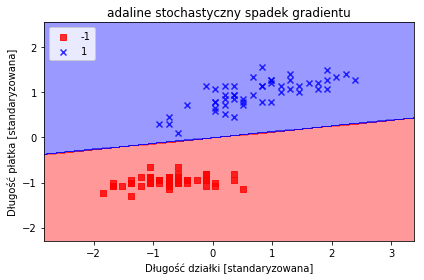

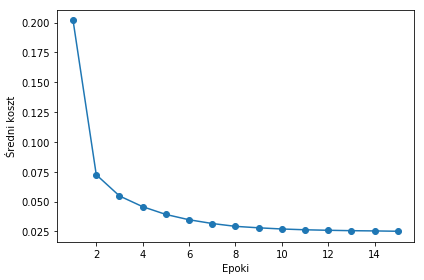

In [17]:
adas = AdalineSGD(n_iter=15, eta=0.01, random_state=1)
adas.fit(X_std, y)
plot_decision_regions(X_std, y, classifier=adas)
plt.title('adaline stochastyczny spadek gradientu')
plt.xlabel('Długość działki [standaryzowana]')
plt.ylabel('Długość płatka [standaryzowana]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

plt.plot(range(1, len(adas.cost_) + 1), adas.cost_, marker='o')
plt.xlabel('Epoki')
plt.ylabel('Średni koszt')
plt.tight_layout()
plt.show()